In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from scipy import stats
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer


In [2]:
# Fijamos el directorio de trabajo
DIRECTORY =  "/home/spperez/masiv_model/"

In [3]:
# Datos
df = pd.read_csv(DIRECTORY + "data/processed/rfm_standardized.csv", index_col="CustomerID")
df.head()

,Recency,Frequency,MonetaryValue,FrequencyStd,RecencyStd,MonetaryValueStd
CustomerID,,,,,,
12346.0,325.0,1,77183.60,-0.425097,2.189389,0.421395
12347.0,2.0,7,4310.00,0.354417,-0.900588,0.250966
12348.0,75.0,4,1797.24,-0.035340,-0.170593,-0.028596
12349.0,18.0,1,1757.55,-0.425097,-0.740589,-0.033012
12350.0,310.0,1,334.40,-0.425097,2.179389,-0.191347


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4338 entries, 12346.0 to 18287.0
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Recency           4338 non-null   float64
 1   Frequency         4338 non-null   int64  
 2   MonetaryValue     4338 non-null   float64
 3   FrequencyStd      4338 non-null   float64
 4   RecencyStd        4338 non-null   float64
 5   MonetaryValueStd  4338 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 237.2 KB


In [5]:
df.describe()

,Recency,Frequency,MonetaryValue,FrequencyStd,RecencyStd,MonetaryValueStd
count,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000,4338.000000
mean,92.059474,4.272015,2054.266460,-0.086313,-0.017466,-0.082438
std,100.012264,7.697998,8989.230441,0.436310,0.955076,0.169799
min,0.000000,1.000000,3.750000,-0.425097,-0.900588,-0.216056
25%,17.000000,1.000000,307.415000,-0.425097,-0.750589,-0.194350
50%,50.000000,2.000000,674.485000,-0.295178,-0.420592,-0.153510
75%,141.750000,5.000000,1661.740000,0.094579,0.496902,-0.043671
max,373.000000,209.000000,280206.020000,1.133930,2.189389,0.421395


In [6]:
df_rmf_std = pd.DataFrame(df, columns=["FrequencyStd", "RecencyStd", "MonetaryValueStd"])
df_rmf_std

,FrequencyStd,RecencyStd,MonetaryValueStd
CustomerID,,,
12346.0,-0.425097,2.189389,0.421395
12347.0,0.354417,-0.900588,0.250966
12348.0,-0.035340,-0.170593,-0.028596
12349.0,-0.425097,-0.740589,-0.033012
12350.0,-0.425097,2.179389,-0.191347
...,...,...,...
18280.0,-0.425097,1.849392,-0.208459
18281.0,-0.425097,0.879399,-0.216056
18282.0,-0.295178,-0.850588,-0.208742


In [7]:
# Número de Grupos
inertias = [] 
K = range(1,10) 
  
for k in K: 
    kmeanModel = KMeans(n_clusters=k, random_state = 123).fit(df_rmf_std) 
    kmeanModel.fit(df_rmf_std)     
    inertias.append(kmeanModel.inertia_) 



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


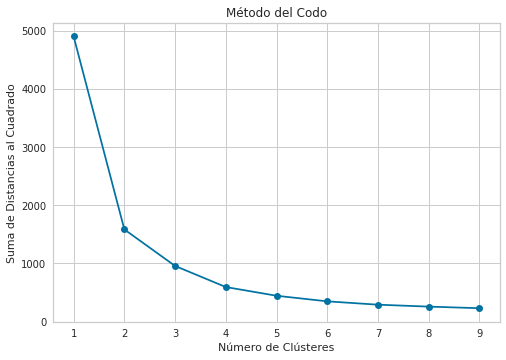

<Figure size 576x396 with 0 Axes>

In [8]:
# Grafico
plt.plot(K, inertias, marker = 'o') 
plt.xlabel('Número de Clústeres') 
plt.ylabel('Suma de Distancias al Cuadrado') 
plt.title('Método del Codo') 
plt.show() 
plt.savefig(DIRECTORY + "reports/figures/grupos.png")

El gráfico de la suma de distancias al cuadrado (Elbow Method) sugiere que el número óptimo de clústeres está entre 4 y 5.

In [9]:
def kmeans(normalised_df_rfm, clusters_number, origin_data):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 123)
    kmeans.fit(normalised_df_rfm)

    # Saca los clústeres
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = origin_data.assign(Cluster = cluster_labels)
    
    # UMAP
    reducer = umap.UMAP(random_state=1234)
    embedding = reducer.fit_transform(normalised_df_rfm)
    
    # Plot
    plt.title("Gráfico de {} Clústeres".format(clusters_number))
    sns.set_theme(style=None)
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new

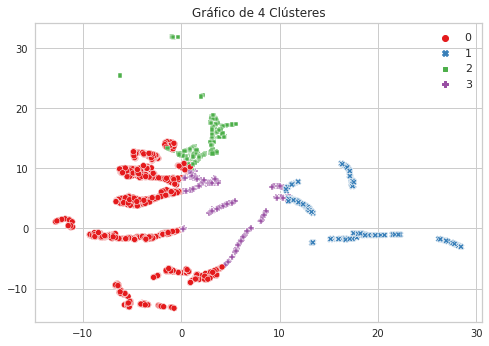

In [10]:
df_rfm_k4 = kmeans(df_rmf_std, 4, df[["Frequency", "Recency", "MonetaryValue"]])
plt.savefig(DIRECTORY + "reports/figures/umap_4c.png")

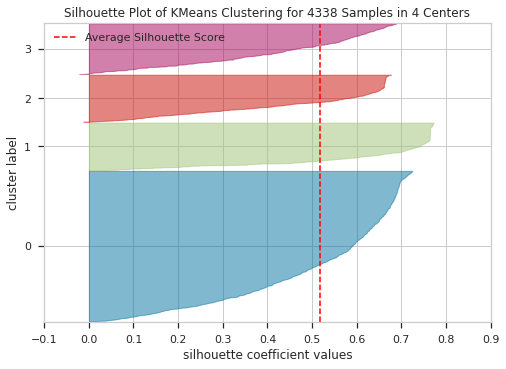

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 4338 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [11]:
# Índice Silhouette
model = KMeans(4, random_state=123)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick', show=False)
visualizer.fit(df_rmf_std)
plt.savefig(DIRECTORY + "reports/figures/silueta_4c.png")
visualizer.show()       

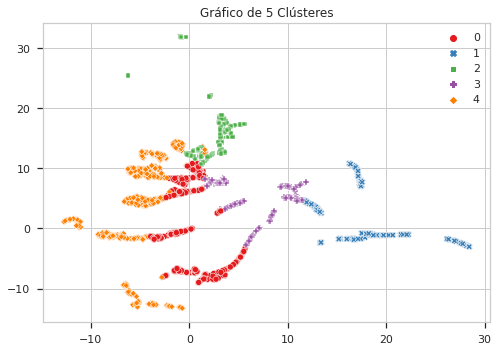

In [12]:
df_rfm_k5 = kmeans(df_rmf_std, 5, df[["Frequency", "Recency", "MonetaryValue"]])

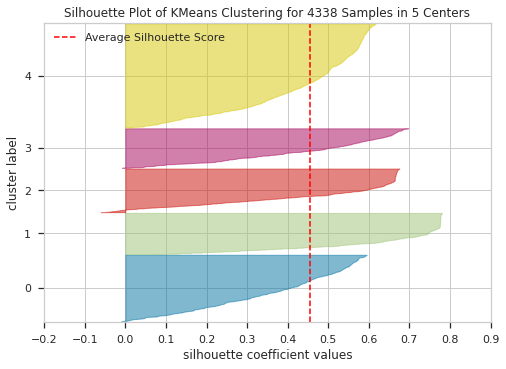

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 4338 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
# Índice Silhouette
model = KMeans(5, random_state=123)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_rmf_std)  
plt.savefig(DIRECTORY + "reports/figures/silueta_5c.png")      
visualizer.show() 

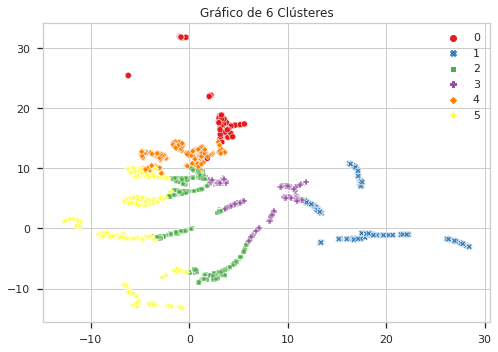

In [14]:
df_rfm_k6 = kmeans(df_rmf_std, 6, df[["Frequency", "Recency", "MonetaryValue"]])

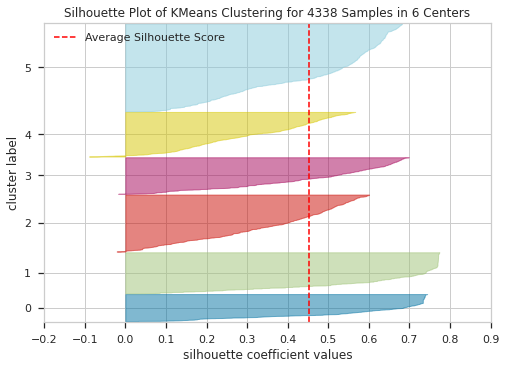

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 4338 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [15]:
# Índice Silhouette
model = KMeans(6, random_state=123)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(df_rmf_std)        
visualizer.show() 

Con ayuda del índice silhouette se selecciona k = 4 como el numero óptimo de clústeres.

In [16]:
# Resumen de las varaibles originales por cada cluster
df_rfm_k4.groupby(["Cluster"]).agg({
    "Recency": ["mean", "min", "max"],
    "Frequency": ["mean", "min", "max"],
    "MonetaryValue": ["mean", "min", "max"]
})

Recency                Frequency          MonetaryValue          \
               mean    min    max       mean min  max          mean     min   
Cluster                                                                       
0         36.252947    0.0   92.0   2.719402   1    7   1069.952241    6.20   
1        285.748212  210.0  373.0   1.374821   1   34    597.078871    3.75   
2         16.549133    0.0  120.0  14.335260   6  209   8008.144595  201.12   
3        146.005398   91.0  217.0   2.229420   1   12    799.054076   15.00   

                    
               max  
Cluster             
0        168472.50  
1         77183.60  
2        280206.02  
3         39916.50

In [17]:
# Tamaño de los clústeres
df_rfm_k4.groupby(["Cluster"]).agg({
    "Recency": lambda x:len(x)
})

,Recency
Cluster,
0,2206
1,699
2,692
3,741


In [18]:
df_rfm_k4

,Frequency,Recency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,1,325.0,77183.60,1
12347.0,7,2.0,4310.00,2
12348.0,4,75.0,1797.24,0
12349.0,1,18.0,1757.55,0
12350.0,1,310.0,334.40,1
...,...,...,...,...
18280.0,1,277.0,180.60,1
18281.0,1,180.0,80.82,3
18282.0,2,7.0,178.05,0


In [19]:
(df_rfm_k4.groupby(["Cluster"]).agg({
    "MonetaryValue": ["sum"]
})/8911407.904)*100

,MonetaryValue
,sum
Cluster,
0,26.486439
1,4.683414
2,62.185865
3,6.644282


In [20]:
(df_rfm_k4.groupby(["Cluster"]).agg({
    "Recency": lambda x:len(x)
})/4338)*100

,Recency
Cluster,
0,50.852928
1,16.113416
2,15.952052
3,17.081604


In [21]:
df_rfm_k4.to_csv(DIRECTORY + "data/processed/customer_segment.csv", index=False)